# Multi-Head Attention for Differential Counting 

The notebook trains a neural network that solves the following task:
Given an input sequence `XY[0-5]+` where `X` and `Y` are two given digits, the task is to count the number of occurrences of `X` and `Y` in the remaining substring and then calculates the difference `#X - #Y`.

```
Example:
Input: 1213211
Output: 2 (3 - 1)
```

The problem is solved with a multi-head attention network.

In [1]:
#!/usr/bin/env python3

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Set random seeds
torch.manual_seed(0)
torch.cuda.manual_seed(0)

SEQ_LEN = 5
VOCAB_SIZE = 6
NUM_TRAINING_STEPS = 25000
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
  !nvidia-smi

Sun Mar 13 01:28:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import time

def timeSince(since: float) -> str:
    s = time.time() - since
    return f"{int(s/60):2}m {int(s%60):02}s"

In [3]:
# This function generates data samples as described above
def get_data_sample(batch_size=1):
    random_seq = torch.randint( low=0, high=VOCAB_SIZE - 1,
                                size=[batch_size, SEQ_LEN + 2])
    X, Y = random_seq[:,0], random_seq[:,1]
    occur = lambda x: (random_seq[:,2:]==x[:,None]).sum(axis=1)
    # Calculates the ground truth output for the random sequence
    gts = occur(X) - occur(Y)
    # Guarantees that GT is non-negative
    # This is a classification problem and as cross-entropy is used for the loss function,
    # it uses the logits to find out the class which is most probable between the others.
    # Thus, it needs the class indices as targets to compare and they would be between [0, C-1]
    # where C is the number of classes. Therefore, it couldn't be fed by negative numbers.
    gts += SEQ_LEN
    return random_seq, gts

In [4]:
# Network definition
class Net(nn.Module):
    def __init__(self, num_encoding_layers=1, num_hidden=64, num_heads=4):
        super().__init__()

        self.embedding = nn.Embedding(VOCAB_SIZE, num_hidden)
        positional_encoding = torch.empty([SEQ_LEN + 2, 1])
        nn.init.normal_(positional_encoding)
        self.positional_encoding = nn.Parameter(positional_encoding,
                                                requires_grad=True)
        q = torch.empty([1, num_hidden])
        nn.init.normal_(q)
        self.q = nn.Parameter(q, requires_grad=True)
        self.encoding_layers = [ EncodingLayer(num_hidden, num_heads).to(device)
                                for _ in range(num_encoding_layers) ]
        self.decoding_layer = MultiHeadAttention(num_hidden, num_heads).to(device)
        self.c1 = nn.Conv1d(num_hidden + 1, num_hidden, 1)
        self.fc1 = nn.Linear(num_hidden, 2 * SEQ_LEN + 1)

    def forward(self, x):
        x = self.embedding(x)
        B = x.shape[0]
        # The input has three parts X, Y, and substring. Thus,
        # we need a mechanism to notify the network of the exact scope of each part,
        # and it's the (trainable) positional encoding which is added to our representation.
        # Imagine we just wanted to count the occurrence of a specific number,
        # for example, number 1, in this case, the network does not need
        # positional encoding as its order doesn't matter here.
        positional_encoding = self.positional_encoding.unsqueeze(0)
        positional_encoding = positional_encoding.repeat([B, 1, 1])
        x = torch.cat([x, positional_encoding], axis=-1)
        x = x.transpose(1, 2)
        x = self.c1(x)
        x = x.transpose(1, 2)
        for encoding_layer in self.encoding_layers:
            x = encoding_layer(x)
        q = self.q.unsqueeze(0).repeat([B, 1, 1])
        x = self.decoding_layer(q, x, x)
        x = x.squeeze(1)
        x = self.fc1(x)
        return x

class EncodingLayer(nn.Module):
    def __init__(self, num_hidden, num_heads):
        super().__init__()
        self.att = MultiHeadAttention(embed_dim=num_hidden, num_heads=num_heads).to(device)
        self.c1 = nn.Conv1d(num_hidden, 2 * num_hidden, 1)
        self.c2 = nn.Conv1d(2 * num_hidden, num_hidden, 1)
        self.norm1 = nn.LayerNorm([num_hidden])
        self.norm2 = nn.LayerNorm([num_hidden])

    def forward(self, x):
        x = self.att(x, x, x)
        x = self.norm1(x)
        x1 = x.transpose(1, 2)
        x1 = self.c1(x1)
        x1 = F.relu(x1)
        x1 = self.c2(x1)
        x1 = F.relu(x1)
        x1 = x1.transpose(1, 2)
        x += x1
        x = self.norm2(x)
        return x

# The following two classes implement Attention and Multi-Head Attention from
# the paper "Attention Is All You Need" by Ashish Vaswani et al.

################################################################################
# The attention mechanism tries to mimic cognitive attention.
# As we know, RNNs do not remember dependencies in long sequences and
# they also are not capable of running in parallel. Attention addresses these issues.
# It applies multi-head self-attention. Self-attention is a linear combination of X.
# Matrices Q, K, and V act like key-value in associative memory.
# Q as a query is used to find best matched within the K (keys) and then
# the output of that is used as a key to retrieve the desired data from V matrix (Values).
# In the following lines, we will implement a naive version of Multi-Head Attention.
################################################################################

class Attention(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.WK = nn.Linear(input_dim, embed_dim, bias=False)
        # It has the same effects of the following code but more concise
        # WK = torch.empty(input_dim, embed_dim)
        # nn.init.normal_(WK)
        # self.WK = nn.Parameter(WK, requires_grad=True)
        self.WQ = nn.Linear(input_dim, embed_dim, bias=False)
        self.WV = nn.Linear(input_dim, embed_dim, bias=False)
        self.embed_dim = embed_dim

    def forward(self, q, k, v):
        # q, k, and v are batch-first
        # First, it calculates a trainable linear projection of q, k and v.
        # Then calculates the scaled dot-product attention as described in
        # Section 3.2.1 of the paper.
        q, k, v = self.WQ(q), self.WK(k), self.WV(v)
        q = q/(self.embed_dim)**.5
        scores = torch.matmul(q, k.transpose(1, 2))
        softmax = F.softmax(scores, dim = -1)
        result = torch.matmul(softmax, v)
        return result

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.dk = embed_dim//num_heads
        self.atts = [Attention(embed_dim, self.dk).to(device) for _ in range(num_heads)]
        self.WO = nn.Linear(embed_dim, embed_dim, bias=False)
        self.num_heads = num_heads

    def forward(self, q, k, v):
        # q, k, and v are batch-first
        # Implemented multi-head attention as described in Section 3.2.2 of the paper.
        heads = [self.atts[i](q,k,v) for i in range(self.num_heads)]
        result = self.WO(torch.cat(heads, dim=-1))
        return result

# Training the Model

In [5]:
# Instantiate network, loss function and optimizer

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

acc_hist, loss_hist = [], []
best_net, best_acc = None, 0

# Train the network
net.train()
start = time.time()
for i in range(1, NUM_TRAINING_STEPS+1):
    inputs, labels = get_data_sample(BATCH_SIZE)
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    accuracy = (torch.argmax(outputs, axis=-1) == labels).float().mean()

    if accuracy.item() > best_acc:
      best_net = net
      best_acc = accuracy.item()

    if i==1 or i%100==0:
        print(f"\r[{i}/{NUM_TRAINING_STEPS}] loss: {loss.item():.3f}, accuracy/best_acc: {accuracy.item():.3f}/{best_acc:.3f}, elapsed time:{timeSince(start)}", end='')
        acc_hist.append(accuracy.item())
        loss_hist.append(loss.item())

# Accuracy and loss of the last run
acc_hist.append(accuracy.item()) 
loss_hist.append(loss.item())

print(f"\nFinal accuracy: {accuracy.item():.3f}, expected {1.0:.3f}")

[25000/25000] loss: 0.087, accuracy/best_acc: 0.984/1.000, elapsed time: 4m 59s
Final accuracy: 0.984, expected 1.000


## Plotting Loss and Accuracy

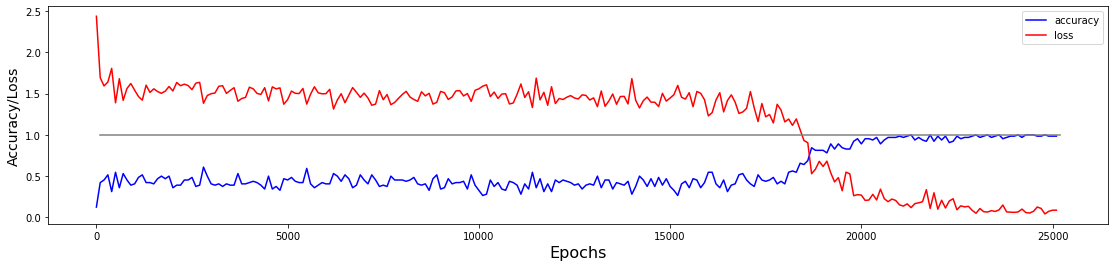

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(19, 4)
ax.set_xlabel('Epochs', fontsize=16)
ax.set_ylabel('Accuracy/Loss', fontsize=14)
plt.plot(acc_hist, 'b', label='accuracy')
plt.plot(loss_hist, 'r', label='loss')
plt.plot([1, len(acc_hist)], [1,1], 'gray')
fig.canvas.draw() # in order to get the text of xticks
labels = [int(item.get_text().replace('−','-'))*100 for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.legend()
plt.show()

# Testing the Model

In [7]:
best_net.eval()
ins, labs= get_data_sample(20)
ins, labs = ins.to(device), labs.to(device)
outs = best_net(ins)

seq = [''.join([(str(_.item())+' ' if i==1 else str(_.item())) for i,_ in enumerate(row)]) for row in ins.cpu()]
gt = [str(_.item()) for _ in labs]
pr = [str(_.item()) for _ in torch.argmax(outs, axis=-1)]

print(f"XY [1-5]+ GT Pr")
print('\n'.join(['  '.join(item) for item in zip(seq, gt, pr)]))

XY [1-5]+ GT Pr
34 42231  5  5
31 04043  6  6
42 12302  3  3
22 40414  5  5
12 01240  5  5
43 23300  3  3
32 21323  5  5
40 34420  6  6
14 30234  4  4
44 23322  5  5
44 24301  5  5
23 44201  6  6
21 24312  6  6
01 04102  6  6
42 34122  4  4
01 30414  5  5
31 23221  5  5
01 34422  5  5
01 42033  6  6
41 21323  4  4
